# Introduction to Random Forest

## Introduction



Over the past lesson, we learned about **Decision Trees**, and looked at ways to reduce overfitting. The most powerful tool for reducing **Decision Tree** overfitting is called the **Random Forest** algorithm. In this lesson, we'll learn how to construct and apply **Random Forests**.

We'll continue using the same 1994 census data set on U.S. income. It contains information on **marital status**, **age**, **type of work**, and **more**. The target column, **high_income**, records salaries less than or equal to 50k a year (0), and more than 50k a year (1).

You can download the data from the [University of California](http://archive.ics.uci.edu/ml/datasets/Adult), Irvine's website.

In [1]:
import pandas as pd

# reading the dataset
income = pd.read_csv("income.csv")
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
# verifying if there are missing values
income.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
high_income       0
dtype: int64

In [3]:
# Transform nominal columns to Categorical
for name in ["workclass","education", "marital_status", "occupation", "relationship", 
             "race", "sex", "native_country", "high_income"]:
    col = pd.Categorical(income[name])
    income[name] = col.codes
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [4]:
import numpy as np
import math

# Set a random seed so the shuffle is the same every time
np.random.seed(1)

# Shuffle the rows  
# This permutes the index randomly using numpy.random.permutation
# Then, it reindexes the dataframe with the result
# The net effect is to put the rows into random order
income = income.reindex(np.random.permutation(income.index))

train_max_row = math.floor(income.shape[0] * .8)
train = income.iloc[:train_max_row]
test = income.iloc[train_max_row:]

## Combining Model Predictions With Ensembles


A **Random Forest** is a kind of ensemble model. [Ensembles](https://en.wikipedia.org/wiki/Ensemble_learning) combine the predictions of multiple models to create a more accurate final prediction. We'll make a simple ensemble to see how they work.

Let's create two decision trees with slightly different parameters:

- One with **min_samples_leaf** set to 2
- One with **max_depth** set to 5

Then, we'll check their accuracies separately. On the next screen, we'll combine their predictions and compare the combined accuracy with the individual accuracies of both trees.

**Exercise Start**

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>


- Fit both **clf** and **clf2** to the data.
  - Use **train[columns]** as the predictors, and **train["high_income"]** as the target.
- Make predictions on the test set predictors (**test[columns]**) using both **clf** and **clf2**.
- For both sets of predictions, compute the AUC between the predictions and the actual values (**test["high_income"]**) using the [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) function.
- Use the **print()** function to display the AUC values for both.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

columns = ["age", "workclass", "education_num", "marital_status", 
           "occupation", "relationship", "race", "sex",
           "hours_per_week", "native_country"]

clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
clf.fit(train[columns], train["high_income"])

clf2 = DecisionTreeClassifier(random_state=1, max_depth=5)
clf2.fit(train[columns], train["high_income"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [7]:
predict1 = clf.predict(test[columns])

predict2 = clf2.predict(test[columns])

# Imprimindo o resultado
print(roc_auc_score(test['high_income'], predict1))
print(roc_auc_score(test['high_income'], predict2))

0.6878964226062301
0.6759853906508785


## Combining Our Predictions




When we have multiple classifiers making predictions, we can treat each set of predictions as a column in a matrix. Here's an example where we have Decision Tree 1 (DT1), Decision Tree 2 (DT2), and Decision Tree 3 (DT3):

```python
DT1     DT2    DT3
0       1      0
1       1      1
0       0      1
1       0      0
```

Whenever we add more models to our ensemble, we just add more columns to the combined predictions. Ultimately, we don't want this matrix, though -- we want one prediction per row in the training data. To accomplish this, we'll need to create rules to convert each row of our matrix of predictions into a single number.

We want to create a **Final Prediction** vector that looks like this:

```python
DT1     DT2    DT3    Final Prediction
0       1      0      0
1       1      1      1
0       0      1      0
1       0      0      0
```

There are many ways to get from the output of multiple models to a final vector of predictions. One method is [**majority voting**](http://www.scholarpedia.org/article/Ensemble_learning#Voting_based_methods), in which each classifier gets a "vote," and the most commonly voted value for each row "wins." This only works if there are more than two classifiers (and ideally an odd number, so we don't have to write a rule to break ties). Majority voting is what we applied in the example above.

**Because we only had two classifiers on the last section**, we'll have to use a different method to combine predictions. We'll take the **mean** of all of the items in a row. Right now, we're using the **predict()** method, which returns either 0 or 1. **predict()** returns something like this:

```python
0
1
0
1
```

We can use the **RandomForestClassifier.predict_proba()** method instead, which will predict a probability from 0 to 1 that a given class is the right one for a row. Because 0 and 1 are our two classes, we'll get a matrix containing the number of rows in the income dataframe, and two columns. **predict_proba()** will return a result that looks like this:


```python
0     1
.7    .3
.2    .8
.1    .9
```

Each row will correspond to a prediction. The first column is the probability that the prediction is a 0, and the second column is the probability that the prediction is a 1. Each row adds up to 1.

If we just take the second column, we get the average value that the classifier would predict for that row. If there's a .9 probability that the correct classification is 1, we can use the .9 as the value the classifier is predicting. This will give us a continuous output in a single vector, instead of just 0 or 1.

Then we can add together all of the vectors we get through this method, and divide the sum by the total number of vectors to get the mean prediction made across the entire ensemble for a particular row. Finally, we round off to get a 0 or 1 prediction for the row.

If we use the **predict_proba()** method on both classifiers from the last screen to generate probabilities, take the mean for each row, and then round the results, we'll get ensemble predictions.


**Exercise Start**

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>


- Add **predictions** and **predictions2**, then divide by 2 to get the **mean**.
- Use **numpy.round()** to round all of the resulting predictions. Store the result in **rounded**.
- Print the resulting **AUC** score between the actual values(**test["high_income"]**) and the predictions (**rounded**).

In [8]:
predictions = clf.predict_proba(test[columns])[:,1]
predictions2 = clf2.predict_proba(test[columns])[:,1]

mean = (predictions + predictions2) / 2
print(roc_auc_score(test['high_income'], np.round(mean)))

0.7150846804038882


## Why Ensembling Works




As we can see from the previous section, the combined predictions of the two trees had a higher AUC than that of either tree on its own:

| settings             | test AUC |
|----------------------|----------|
| min_samples_leaf: 2  | 0.688    |
| max_depth: 2         | 0.676    |
| combined predictions | 0.715    |

To intuitively understand why this makes sense, think about two people with the same level of talent. One learned programming in college, while the other learned it on her own.

If we give both of them the same project, they'll approach it in slightly different ways, due to their different experiences. They may both produce code that achieves the same result, but one may run faster in certain areas. The other may have a better interface. Even though both of them have about the same level of talent, their solutions are stronger in different areas because they approached the problem differently.

If we combine the best parts of both of their projects, we'll end up with a stronger combined project.

Ensembling is exactly the same. The models are approaching the same problem in slightly different ways, and building different trees because we used different parameters for each one. Each tree makes different predictions in different areas. Even though both trees have about the same accuracy, when we combine them, the result is stronger because it leverages the strengths of both approaches.

The more "diverse" or dissimilar the models we use to construct an ensemble are, the stronger their combined predictions will be (assuming that all of the models have about the same accuracy). **Ensembling a decision tree and a logistic regression model, for example, will result in stronger predictions than ensembling two decision trees with similar parameters.** That's because those two models use very different approaches to arrive at their answers.

On the other hand, if the models we ensemble are very similar in how they make predictions, ensembling will result in a negligible boost.

**Ensembling models with very different accuracies generally won't improve overall accuracy.** Ensembling a model with a .75 AUC and a model with a .85 AUC on a test set will usually result in an AUC somewhere in between the two original values. There's a way around this that we'll discuss later on, which we call **weighting**.

## Introducing Variation With Bagging




A **Random Forest** is an ensemble of **Decision Trees**. If we don't make any modifications to the trees, each tree will be exactly the same, so we'll get no boost when we ensemble them. In order to make ensembling effective, **we have to introduce variation** into each individual decision tree model.

If we introduce variation, each tree will be be constructed slightly differently, and will therefore make different predictions. **This variation is what puts the "random" in "Random Forest."**

There are **two main ways to introduce variation** in a Random Forest -- **bagging** and **random feature subsets**. We'll dive into bagging first.

In a Random Forest, we don't train each tree on the entire data set. We train it on a random sample of the data, or a "bag," instead. We perform this sampling with replacement, which means that after we select a row from the data we're sampling, we put the row back in the data so it can be picked again. Some rows from the original data may appear in the "bag" multiple times.

Let's use bagging with the first tree we trained.


**Exercise Start**

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>

- **predictions** is a list of vectors corresponding to predictions on the test set.
- Use the technique we employed earlier to add all of the vectors together, and divide by 10 to get the **mean** prediction for each row.
- Use **numpy.round()** to round the resulting predictions.
- Finally, print the **AUC** score between the combined predictions and **test["high_income"].**

In [9]:
# We'll build 10 trees
tree_count = 10

# Each "bag" will have 60% of the number of original rows
bag_proportion = .6

predictions = []
for i in range(tree_count):
    # We select 60% of the rows from train, sampling with replacement
    # We set a random state to ensure we'll be able to replicate our results
    # We set it to i instead of a fixed value so we don't get the same sample
    # in every loop. That would make all of our trees the same
    bag = train.sample(frac=bag_proportion, replace=True, random_state=i)
    
    # Fit a decision tree model to the "bag"
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
    clf.fit(bag[columns], bag["high_income"])
    
    # Using the model, make predictions on the test data
    predictions.append(clf.predict_proba(test[columns])[:,1])
    
mean = sum(predictions) / len(predictions)
print(roc_auc_score(test['high_income'], np.round(mean)))

0.7329963297474371


## Selecting Random Features




Using the **bagging** example from the previous section, we gained some accuracy over a single **Decision Tree**. To be exact, we achieved an AUC score of around .733 with **bagging**, which is an improvement over the AUC score of .688 we got **without bagging**:

| settings                          | test AUC |
|-----------------------------------|----------|
| min_samples_leaf: 2               | 0.688    |
| max_depth: 2                      | 0.676    |
| combined predictions              | 0.715    |
| min_samples_leaf: 2, with bagging | 0.732    |

Let's go back to the **Decision Tree** algorithm we explored in last lesson to explain random feature subsets:

- First we pick the maximum number of features we want to evaluate each time we split the tree.
    - This has to be less than the total number of columns in the data.
- Every time we split, we pick a random sample of features from the data.
- Then we compute the information gain for each feature in our random sample, and pick the one with the highest information gain to split on.
To understand how splits work, let's look at information gain or entropy. Entropy is the measure of "disorder" in the data set. If a dataset has all the same labels, they'll have low entropy. If all the labels are different, they'll have high entropy. Splits that give us more information about the data, will ideally minimize entropy. In other words, the tree will ideally split the labels into distinct groups with as little mixture possible. This'll allow the splits to give our tree more predictive power.

We're repeating the same process to select the optimal split that minimizes entropy for a node. However, we'll only evaluate a constrained set of features that we select randomly. This introduces variation into the trees, and makes for more powerful ensembles.

## Random Subsets in scikit-learn




We can also repeat our random subset selection process in scikit-learn. We just set the **splitter** parameter on **DecisionTreeClassifier** to **"random"**, and the **max_features** parameter to **"auto"**. If we have N columns, this will pick a subset of features of size $\sqrt{N}$, compute the Gini coefficient for each (this is similar to information gain), and split the node on the best column in the subset.


**Exercise Start**

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>

- Modify the instantiation of the **DecisionTreeClassifier** object.
- Set **splitter** to **"random"**, and **max_features** to **"auto"**.
- Print the resulting **AUC** score.

In [11]:
# We'll build 10 trees
tree_count = 10

# Each "bag" will have 60% of the number of original rows
bag_proportion = .6

predictions = []
for i in range(tree_count):
    # We select 60% of the rows from train, sampling with replacement
    # We set a random state to ensure we'll be able to replicate our results
    # We set it to i instead of a fixed value so we don't get the same sample every time
    bag = train.sample(frac=bag_proportion, replace=True, random_state=i)
    
    # Fit a decision tree model to the "bag"
    
    # PUT YOUR CODE HERE
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2,
                                splitter='random', max_features='auto')
    #
    #
    
    clf.fit(bag[columns], bag["high_income"])
    
    # Using the model, make predictions on the test data
    predictions.append(clf.predict_proba(test[columns])[:,1])

combined = np.sum(predictions, axis=0) / 10
rounded = np.round(combined)

print(roc_auc_score(test["high_income"], rounded))

0.7345958637997538


## Practice Putting it All Together




Using random subsets from the previous section improved the accuracy over using bagging alone:

| settings                                             | test AUC |
|------------------------------------------------------|----------|
| min_samples_leaf: 2                                  | 0.688    |
| max_depth: 2                                         | 0.676    |
| combined predictions                                 | 0.715    |
| min_samples_leaf: 2, with bagging                    | 0.732    |
| min_samples_leaf: 2, with bagging and random subsets | 0.734    |

So far, we've demonstrated the two building blocks of **Random Forests**, **bagging** and **random feature subsets**. Luckily, we don't have to write code from scratch each time. Scikit-learn has a [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class and a [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) class that enable us to train and test random forest models quickly.

When we instantiate a **RandomForestClassifier**, we pass in an **n_estimators** parameter that indicates how many trees to build. While adding more trees usually improves accuracy, it also increases the overall time the model takes to train.

**RandomForestClassifier** has a similar interface to **DecisionTreeClassifier**, and we can use the **fit()** and **predict()** methods to train and make predictions.

**Exercise Start**

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>


- Fit **clf** to the training data and make predictions on the test data.
- Compute and print the AUC score between the test predictions and the actual values.

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=5, random_state=1, 
                             min_samples_leaf=2)

clf.fit(train[columns], train['high_income'])

predictions = clf.predict(test[columns])

roc_auc_score(test['high_income'], predictions)

0.7347461391939776

## Tweaking Parameters to Increase Accuracy




Similar to **Decision Trees**, we can tweak some of the parameters for **Random Forests**, including:

- **min_samples_leaf**
- **min_samples_split**
- **max_depth**
- **max_leaf_nodes**

These parameters apply to the individual trees in the model, and change how they are constructed. There are also parameters specific to the **Random Forest** that alter its overall construction:

- **n_estimators**
- **bootstrap** - "Bootstrap aggregation" is another name for bagging; this parameter indicates whether to turn it on (Defaults to True)

Refer to the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for a full list of parameters.

Tweaking parameters can increase the accuracy of the forest. The easiest tweak is to increase the number of estimators we use. This approach yields diminishing returns -- going from 10 trees to 100 will make a bigger difference than going from 100 to 500, which will make a bigger difference than going from 500 to 1000. The accuracy increase function is logarithmic, so increasing the number of trees beyond a certain number (usually 200) won't help much at all.

**Exercise Start**

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>

- Increase **n_estimators** to 150.

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=1, 
                             min_samples_leaf=2)

clf.fit(train[columns], train["high_income"])

predictions = clf.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

0.7379403213124711


## Reducing Overfitting




We were able to improve the AUC from 0.735 to 0.738, but the model using 150 trees took much longer to train. While the extra training time is trivial on the data set we're working with right now, understanding this trade-off will help you when you're working with much larger data sets where the extra time could amount to hours or days!

One of the major advantages of **Random Forests** over single **Decision Trees** is that they tend to overfit less. Although each individual Decision Tree in a Random Forest varies widely, the average of their predictions is less sensitive to the input data than a single tree is. This is because while one tree can construct an incorrect and overfit model, the average of 100 or more trees will be more likely to hone in on the signal and ignore the noise. The signal will be the same across all of the trees, whereas each tree will hone in on the noise differently. This means that the average will discard the noise and keep the signal.

In the following code cell, you'll see that we've fit a single decision tree to the training set, and made predictions for both the training and testing sets. The AUC for the training set predictions is .819, while the AUC for the testing set is .714. The fact that the test AUC is much lower than the train AUC indicates that the model is overfitting.



In [18]:
clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=5)

clf.fit(train[columns], train["high_income"])

predictions = clf.predict(train[columns])
print(roc_auc_score(train["high_income"], predictions))

for score,name in sorted(zip(clf.feature_importances_,columns),reverse=True):
    print('{} has a importance of {}'.format(name,score))

predictions = clf.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

0.8192570489534683
relationship has a importance of 0.35486065267354705
education_num has a importance of 0.2238305467772321
age has a importance of 0.16626910165605044
hours_per_week has a importance of 0.09802596230288446
occupation has a importance of 0.08434714139306755
workclass has a importance of 0.039372047642714826
race has a importance of 0.009447315730049248
native_country has a importance of 0.009270711003041526
sex has a importance of 0.007713429852542139
marital_status has a importance of 0.006863090968870699
0.7139325899284541




Now let's train a similar random forest model and contrast it with what we just did.


**Exercise Start**

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>

- Fit **clf** to the training set and use it to **make predictions** on the **training** set.
- Then, use it to **make predictions** on the **testing** set.
- Print both AUC scores.



In [19]:
clf = RandomForestClassifier(n_estimators=150, 
                             random_state=1, 
                             min_samples_leaf=5)

clf.fit(train[columns], train['high_income'])

predictions = clf.predict(train[columns])
print(roc_auc_score(train["high_income"], predictions))

predictions = clf.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

0.7917047295143252
0.7498874343962398


# Case Study: prediction bike rentals

## Introduction to the Data Set

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

**Hadi Fanaee-T** at the [University of Porto](http://www.up.pt/) compiled this data into a CSV file, which you'll be working with in this project. The file contains **17380** rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, [Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

Here's what the first five rows look like:

In [20]:
import pandas as pd

bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here are the descriptions for the relevant columns:

- **instant** - A unique sequential ID number for each row
- **dteday** - The date of the rentals
- **season** - The season in which the rentals occurred (1:springer, 2:summer, 3:fall, 4:winter)
- **yr** - The year the rentals occurred (0: 2011, 1:2012)
- **mnth** - The month the rentals occurred (1 to 12)
- **hr** - The hour the rentals occurred (0 to 23)
- **holiday** - Whether or not the day was a holiday
- **weekday** - The day of the week (as a number, 0 to 7)
- **workingday** - Whether or not the day was a working day
- **weathersit** - The weather (as a categorical variable)
- **temp** - The temperature, on a 0-1 scale
- **atemp** - The adjusted temperature
- **hum** - The humidity, on a 0-1 scale
- **windspeed** - The wind speed, on a 0-1 scale
- **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- **registered** - The number of registered riders (people who had already signed up)
- **cnt** - The total number of bike rentals (casual + registered)

In this mission, you'll try to **predict the total number of bikes people rented in a given hour**. You'll predict the **cnt** column using all of the other columns, except for **casual** and **registered**. To accomplish this, you'll create a few different machine learning models and evaluate their performance.


**Exercise Start**

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>


- Make a **histogram** of the **cnt** column of **bike_rentals**, and take a look at the distribution of total rentals.
- Use the **corr** method on the **bike_rentals** dataframe to explore how each column is correlated with **cnt**.

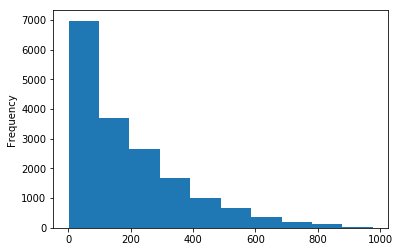

In [22]:
bike_rentals.cnt.plot(kind='hist')

In [24]:
bike_rentals.corr()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.404046,0.866014,0.489164,-0.004775,0.014723,0.001357,-0.003416,-0.014198,0.136178,0.137615,0.009577,-0.074505,0.158295,0.282046,0.278379
season,0.404046,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
yr,0.866014,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.489164,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.004775,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.014723,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,0.001357,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.003416,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,-0.014198,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.136178,0.312025,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772


## Calculating Features

It can often be helpful to calculate **features** before applying machine learning models. **Features** can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the **hr** column in **bike_rentals** contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for **morning**, **afternoon**, **evening**, and **night**. This will bundle similar times together, enabling the model to make better decisions.

**Exercise Start**

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>

- Write a function called **assign_label** that takes in a numeric value for an hour, and returns:
  - 1 if the hour is from 6 to 12
  - 2 if the hour is from 12 to 18
  - 3 if the hour is from 18 to 24
  - 4 if the hour is from 0 to 6
- Use the [apply](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.apply.html) method on series objects to apply the function to each item in the **hr** column.
- Assign the result to the **time_label** column of **bike_rentals.**

In [25]:
def assign_label(value):
    if value < 6:
        return 4
    elif value < 12:
        return 1
    elif value < 18:
        return 2
    elif value < 24:
        return 3

In [26]:
bike_rentals['time_label'] = bike_rentals.hr.apply(assign_label)

## Splitting the Data Into Train and Test Sets

Before you can begin applying machine learning algorithms, you'll need to split the data into **training** and **testing** sets. This will enable you to train an algorithm using the training set, and evaluate its accuracy on the testing set. If you train an algorithm on the training data, then evaluate its performance on the same data, you can get an unrealistically low error value, due to overfitting.


<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>

- Based on your explorations of the **cnt** column, pick an **error metric** you want to use to evaluate the performance of the machine learning algorithms. Explain why you chose this metric in a markdown cell.
- Select 80% of the rows in **bike_rentals** to be part of the **training set** using the [sample method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html) on **bike_rentals**. Assign the result to **train.**
- Select the rows that are in **bike_rentals** but not in train to be in the **testing set**. Assign the result to **test.**
    - This line will generate a Boolean series that's **False** when a row in **bike_rentals** isn't found in **train**:
    ```python
    bike_rentals.index.isin(train.index)
    ```
    - This line will select any rows in **bike_rentals** that aren't found in **train** to be in the testing set: 
    ```python
    bike_rentals.loc[~bike_rentals.index.isin(train.index)]
    ```

In [42]:
from sklearn.model_selection import train_test_split

cols = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'time_label']

# train, test = train_test_split(bike_rentals, test_size=0.2)
train = bike_rentals.sample(n=int(bike_rentals.shape[0]*.8))
test = bike_rentals[~bike_rentals.index.isin(train.index)]

In [43]:
test.shape

(3476, 18)

## Applying Linear Regression

Now that you've done some exploration and manipulation, you're ready to apply **linear regression** to the data. Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with **cnt**.

As you learned in earlier lessons, **linear regression works best when predictors are linearly correlated to the target** and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that **linear regression usually isn't the most accurate option.**

You'll need to **ignore** the **casual** and **registered** columns because **cnt** is derived from them. If you're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that you'd already know casual or registered, because those numbers are added together to get cnt.

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>

- Create a list of predictor columns to use in training and predictions.
    - At a minimum, this list should exclude the **cnt**, **casual**, **dteday**, and **registered** columns.
    - Feel free to remove other columns you don't think will be useful for the predictions.
- Use the [LinearRegression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn to train a machine learning algorithm on **train**.
    - Use only the columns in the list of predictors for this.
- Make predictions using the [LinearRegression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) on **test.**
    - Use the exact same predictor columns here.
- Calculate the error between the predictions and the actual values.
- Write your thoughts about the predictions and the error in a markdown cell.

In [45]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(train[cols], train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [46]:
import numpy as np
predictions = reg.predict(test[cols])

np.sqrt(np.mean((predictions - test['cnt']) ** 2))

127.66832239012227

## Applying Decision Tree

Now you're ready to apply the **decision tree** algorithm. You'll be able to compare its error with the error from linear regression, which will enable you to pick the right algorithm for this data set.

**Decision trees** tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like **maximum depth** and **minimum number of samples** per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>

- Use the [DecisionTreeRegressor class](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) to fit a decision tree algorithm to the **train** data.
- Make predictions using the [DecisionTreeRegressor class](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) on **test**.
- Calculate the error between the predictions and the actual values.
- Experiment with various parameters of the [DecisionTreeRegressor class](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), including **min_samples_leaf**, to see if it changes the error.
- Write your thoughts on the predictions and the error in a markdown cell.


In [48]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf=2)

reg.fit(train[cols], train['cnt'])

predictions = reg.predict(test[cols])

np.sqrt(np.mean((predictions - test['cnt']) ** 2))

55.276190448810596

## Applying Random Forests

You can now apply the **random forest** algorithm, which improves on the decision tree algorithm. **Random forests tend to be much more accurate than simple models like linear regression**. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like **maximum depth** and **minimum samples per leaf**.

<left><img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ"></left>

- Use the [RandomForestRegressor class](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) to fit a random forest algorithm to the **train** data.
- Make predictions using the **RandomForestRegressor** class on **test**.
- Calculate the error between the predictions and the actual values.
- Experiment with various parameters of the **RandomForestRegressor** class, including **min_samples_leaf**, to see if it changes the error.
- Write your thoughts on the predictions and the error in a markdown cell.

In [54]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, min_samples_leaf=2)

reg.fit(train[cols], train['cnt'])

predict = reg.predict(test[cols])

np.sqrt(np.mean((predict - test['cnt']) ** 2))

41.08820595736593

## Next Steps

We recommend exploring the data more on your own.

Here are some potential next steps:

- Calculate additional features, such as:
    - An index combining **temperature**, **humidity**, and **wind speed**
- Try predicting **casual** and **registered** instead of **cnt**.

In [22]:
# put your code here'

# When to Use Random Forests




As we can see in the code cell from the previous section, overfitting decreased with a Random Forest, and accuracy went up overall.

While the random forest algorithm is incredibly powerful, it isn't applicable to all tasks. The main **strengths** of a **Random Forest** are:

- **Very accurate predictions** - Random forests achieve near state-of-the-art performance on many machine learning tasks. Along with neural networks and gradient-boosted trees, they're typically one of the top-performing algorithms.
- **Resistance to overfitting** - Due to their construction, Random Forests are fairly resistant to overfitting. We still need to set and tweak parameters like **max_depth** though.

The main **weaknesses** of using a **Random Forest** are:

- **They're difficult to interpret** - Because we've averaging the results of many trees, it can be hard to figure out why a Random Forest is making predictions the way it is.
- **They take longer to create** - Making two trees takes twice as long as making one, making three takes three times as long, and so on. Fortunately, we can exploit multicore processors to parallelize tree construction. Scikit allows us to do this through the **n_jobs** parameter on [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). We'll discuss parallelization in greater detail later on.

Given these trade-offs, it makes sense to use Random Forests in situations where accuracy is of the utmost importance; being able to interpret or explain the decisions the model is making isn't key. In cases where time is of the essence or interpretability is important, a single decision tree may be a better choice.